## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Васильев Семён Михайлович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

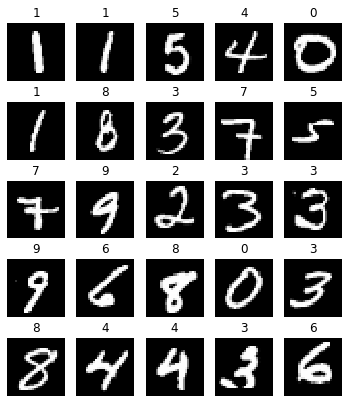

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)
    
def he_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0])
    weight.normal_(mean=0, std=np.sqrt(d))

init_f = xavier_init_uni
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9832369089126587
forward 1.0915104150772095
forward 1.0955700874328613
forward 1.0979037284851074
forward 1.1114414930343628
forward 1.1174249649047852
forward 1.1217663288116455
forward 1.0979379415512085
forward 1.1063461303710938
forward 1.085544466972351
backward 0.024037005379796028
backward 0.019000565633177757
backward 0.019110605120658875
backward 0.01953737996518612
backward 0.018264293670654297
backward 0.01780666410923004
backward 0.01673246920108795
backward 0.01653464138507843
backward 0.016665879637002945
backward 0.015924392268061638


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
init_f = dumb_init
    
net = []
net.append(make_linear(28*28, 500, init_f))
net.append(nn.Tanh())
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.Tanh())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9832369089126587
forward 0.9839926958084106
forward 0.9812382459640503
forward 0.9809357523918152
forward 0.9818015694618225
forward 0.981601893901825
forward 0.9814820885658264
forward 0.9814298748970032
forward 0.9815206527709961
forward 0.981831431388855
backward 0.024037005379796028
backward 0.01872861571609974
backward 0.05348832160234451
backward 0.17541086673736572
backward 0.6093562245368958
backward 2.2844502925872803
backward 7.3374738693237305
backward 25.680500030517578
backward 97.0351333618164
backward 312.1877136230469


In [10]:
init_f = xavier_init_uni
    
net = []
net.append(make_linear(28*28, 500, init_f))
net.append(nn.Tanh())
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.Tanh())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9832369089126587
forward 0.6411351561546326
forward 0.4939519762992859
forward 0.41388076543807983
forward 0.35954806208610535
forward 0.3290962278842926
forward 0.29798564314842224
forward 0.2750343084335327
forward 0.25736695528030396
forward 0.2420082688331604
backward 0.024037005379796028
backward 0.019996939226984978
backward 0.019041268154978752
backward 0.017828309908509254
backward 0.01672324724495411
backward 0.013980245217680931
backward 0.012475351803004742
backward 0.010976394638419151
backward 0.008973006159067154
backward 0.00564836198464036


In [11]:
init_f = he_init
    
net = []
net.append(make_linear(28*28, 500, init_f))
net.append(nn.ReLU())
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.ReLU())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9832369089126587
forward 1.022316336631775
forward 1.034394383430481
forward 1.0372051000595093
forward 0.9857478737831116
forward 0.96507328748703
forward 0.9620215892791748
forward 1.0048763751983643
forward 1.0733145475387573
forward 1.104278802871704
backward 0.024037005379796028
backward 0.10071096569299698
backward 0.09609973430633545
backward 0.09011564403772354
backward 0.07690726965665817
backward 0.07137297838926315
backward 0.0613807775080204
backward 0.05710631236433983
backward 0.051145363599061966
backward 0.04509572312235832


<i> 1.4 Сделайте выводы по первой части </i>

При инициализации весов распределением N(0, 1) дисперсия градиентов для первого и последнего слоя различается на 4 порядка.
При инициализациях Xavier и He для функций активации Tanh и ReLU соответственно дисперсии градиентов на различных слоях отличаются не более, чем на 1 порядок.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [12]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        w = Variable(torch.FloatTensor(input_dim, output_dim).uniform_(-np.sqrt(1 / input_dim), np.sqrt(1 / input_dim)))
        b = Variable(torch.FloatTensor(output_dim).uniform_(-np.sqrt(1 / input_dim), np.sqrt(1 / input_dim)))
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(b)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.weight) * self.p
        if self.training:
            mask = torch.bernoulli(mask)
        mask = mask.data
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [13]:
net = [Flatten()]

net.append(nn.Linear(784, 200))
net.append(nn.Dropout(0.5))
net.append(nn.ReLU())
net.append(nn.Linear(200, 200))
net.append(nn.Dropout(0.5))
net.append(nn.ReLU())
  
net.append(nn.Linear(200, 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.628/0.325	Accuracy: 0.838/0.928


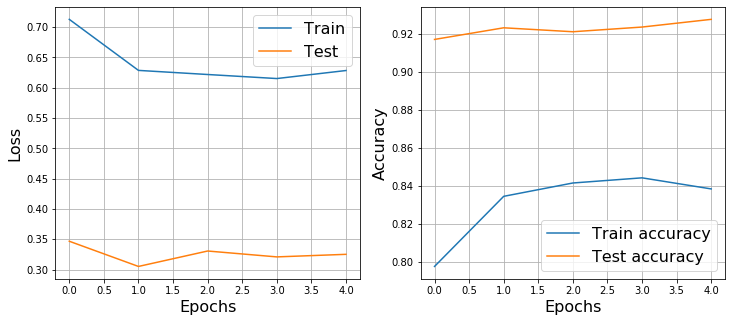

In [14]:
tr_loss_1, test_loss_1, tr_acc_1, test_acc_1 = train(net, train_loader, test_loader, 5, 0.01, device='cpu')

In [15]:
net = [Flatten()]

net.append(DropConnect(784, 200))
net.append(nn.ReLU())
net.append(DropConnect(200, 200))
net.append(nn.ReLU())
  
net.append(nn.Linear(200, 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.251/0.134	Accuracy: 0.932/0.961


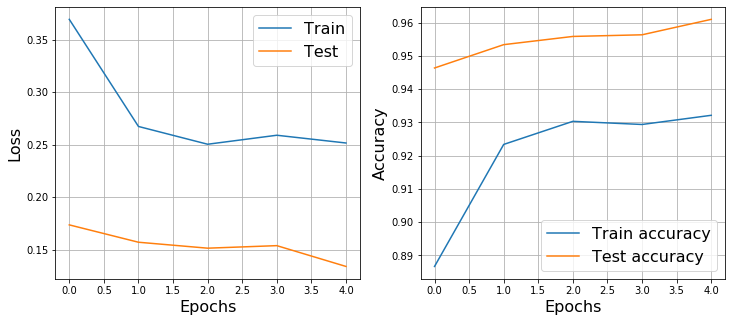

In [16]:
tr_loss_2, test_loss_2, tr_acc_2, test_acc_2 = train(net, train_loader, test_loader, 5, 0.01, device='cpu')

2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике

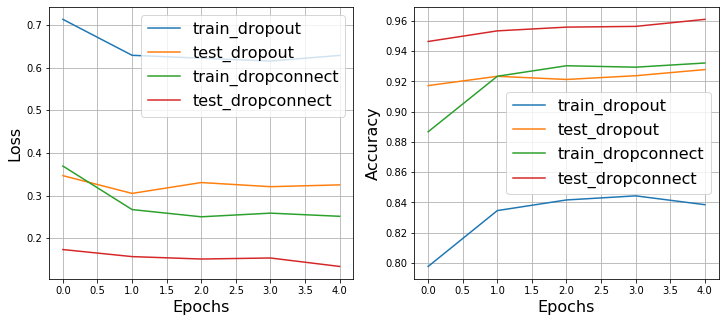

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tr_loss_1, label='train_dropout')
plt.plot(test_loss_1, label='test_dropout')
plt.plot(tr_loss_2, label='train_dropconnect')
plt.plot(test_loss_2, label='test_dropconnect')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(tr_acc_1, label='train_dropout')
plt.plot(test_acc_1, label='test_dropout')
plt.plot(tr_acc_2, label='train_dropconnect')
plt.plot(test_acc_2, label='test_dropconnect')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Dropconnect убучается быстрее.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [25]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim, eps=1e-10):
        super(LayerNormalization, self).__init__()
        self.input_dim = input_dim
        self.gamma = nn.Parameter(Variable(torch.Tensor(self.input_dim)))
        self.beta = nn.Parameter(Variable(torch.Tensor(self.input_dim)))
        self.eps = eps
    
    def forward(self, x):
        output = x - x.mean(dim=1).view(-1, 1)
        output = output / (output.std(dim=1).view(-1, 1) + self.eps)
        output = self.gamma * output + self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [26]:
net = [Flatten()]

net.append(nn.Linear(784, 200))
net.append(nn.ReLU())
net.append(nn.BatchNorm1d(200))
net.append(nn.Linear(200, 200))
net.append(nn.ReLU())
net.append(nn.BatchNorm1d(200))
  
net.append(nn.Linear(200, 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.066/0.084	Accuracy: 0.979/0.975


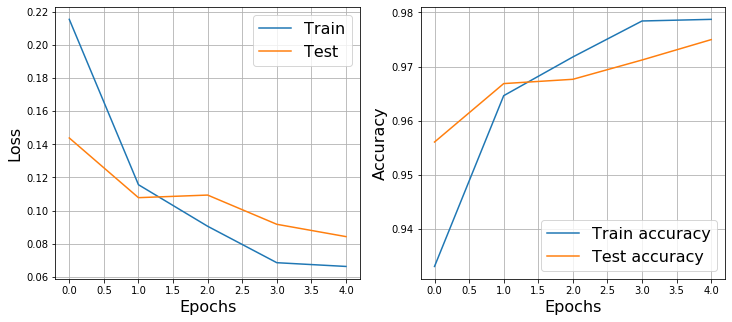

In [27]:
tr_loss_1, test_loss_1, tr_acc_1, test_acc_1 = train(net, train_loader, test_loader, 5, 0.01, device='cpu')

In [28]:
net = [Flatten()]

net.append(nn.Linear(784, 200))
net.append(nn.ReLU())
net.append(LayerNormalization(200))
net.append(nn.Linear(200, 200))
net.append(nn.ReLU())
net.append(LayerNormalization(200))
  
net.append(nn.Linear(200, 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.116/0.209	Accuracy: 0.965/0.943


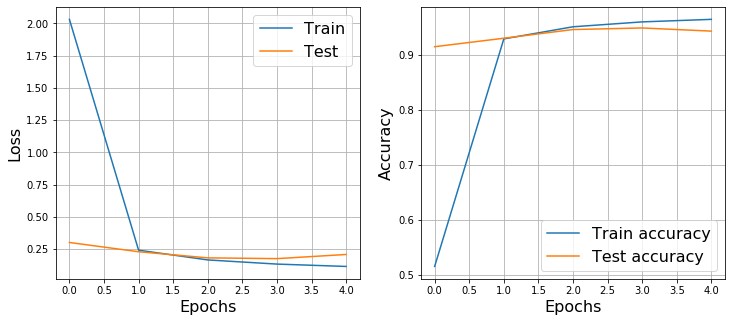

In [29]:
tr_loss_2, test_loss_2, tr_acc_2, test_acc_2 = train(net, train_loader, test_loader, 5, 0.01, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

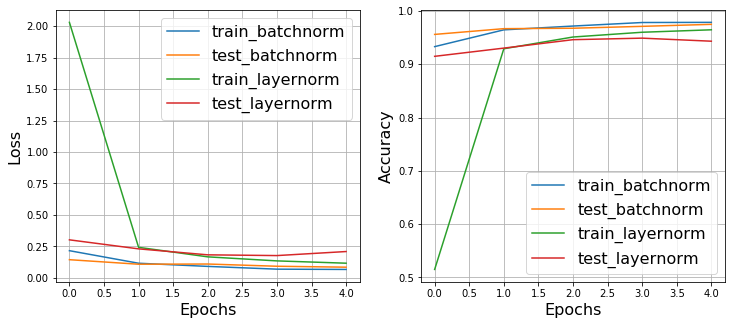

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tr_loss_1, label='train_batchnorm')
plt.plot(test_loss_1, label='test_batchnorm')
plt.plot(tr_loss_2, label='train_layernorm')
plt.plot(test_loss_2, label='test_layernorm')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(tr_acc_1, label='train_batchnorm')
plt.plot(test_acc_1, label='test_batchnorm')
plt.plot(tr_acc_2, label='train_layernorm')
plt.plot(test_acc_2, label='test_layernorm')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: